In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv('nyc_taxi_trip_duration.csv')
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


#### Data Attributes Description

- id - a unique identifier for each trip
- vendor_id - a code indicating the provider associated with the trip record
- pickup_datetime - date and time when the meter was engaged
- dropoff_datetime - date and time when the meter was disengaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged
- store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
- trip_duration - (target) duration of the trip in seconds

#### Check Missing values in the dataset

In [4]:
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

The dataset features do not have any missing values. Let us proceed with the Exploratory Data Analysis of the dataset

#### Analyze geospatial features (pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)

In [5]:
!pip install geopy

In [6]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

#### Below function is computationally expensive as it will have multiple api calls run for a small subset of data. Most of the cities are of New York

In [7]:
def process_record(row,col1,col2):
    coord = f"{row[col1]}, {row[col2]}"
    col_prefix=col1.split('_')[0]
    location = geolocator.reverse(coord, exactly_one=True)
    address = location.raw['address']
    city = address.get('city', '')
    state = address.get('state', '')
    country = address.get('country', '')
    row[f'{col_prefix}_city'] = city
    row[f'{col_prefix}_state'] = state
    row[f'{col_prefix}_country'] = country
    return row

def city_state_country(row):
    row = process_record(row,'pickup_latitude','pickup_longitude')
    row = process_record(row,'dropoff_latitude','dropoff_longitude')
    return row

geo_data = data.iloc[:50,:].apply(city_state_country, axis=1)

#### Plot route between subset of data

In [8]:
!pip install folium

In [9]:
import folium
m = folium.Map([max(geo_data['pickup_latitude'].max(),geo_data['dropoff_latitude'].max()), max(geo_data['pickup_longitude'].max(),geo_data['dropoff_longitude'].max())], zoom_start=11)
for _, row in geo_data.iterrows():
    folium.CircleMarker([row['pickup_latitude'], row['pickup_longitude']],
                        radius=3,
                        fill_color="#3db7e4", # divvy color
                       ).add_to(m)

    folium.CircleMarker([row['dropoff_latitude'], row['dropoff_longitude']],
                        radius=3,
                        fill_color="red", # divvy color
                       ).add_to(m)

    folium.PolyLine([[row['pickup_latitude'], row['pickup_longitude']], 
                     [row['dropoff_latitude'], row['dropoff_longitude']]]).add_to(m)
m

From the above map, we can see the first 50 routes between the pickup and dropoff locations are overlapping and concentrated around a region since it spans across the cities of New York

#### Modelling from date time features(pickup_datetime and dropoff_datetime) new features month, day of week and day_state features

In [10]:
def process_datetime_features(data,col):
    col_prefix = col.split('_')[0]
    bins = [0,4,8,12,16,20,24]
    day_state = ['Late Night', 'Early Morning','Morning','Noon','Evening','Night']
    data[col] = pd.to_datetime(data[col])
    data[f'{col_prefix}_day'] = data[col].dt.day_name()
    data[f'{col_prefix}_month'] = data[col].dt.month_name()
    data[f'{col_prefix}_hour'] = data[col].dt.hour
    data[f'{col_prefix}_day_state'] = pd.cut(data[f'{col_prefix}_hour'], bins=bins, labels=day_state, include_lowest=True)
    data.drop([f'{col_prefix}_hour', col], axis=1,inplace=True)
    return data

In [11]:
assert len(pd.to_datetime(data.pickup_datetime).dt.year.unique()) == 1

There is only one unique year present in pickup_datetime feature hence will not model feature out of it

In [12]:
assert len(pd.to_datetime(data.dropoff_datetime).dt.year.unique()) == 1

There is only one unique year present in dropoff_datetime feature hence will not model feature out of it

In [13]:
data = process_datetime_features(data,'pickup_datetime')
data = process_datetime_features(data,'dropoff_datetime')

In [14]:
data

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_day_state,dropoff_day,dropoff_month,dropoff_day_state
0,id1080784,2,1,-73.953918,40.778873,-73.963875,40.771164,N,400,Monday,February,Noon,Monday,February,Noon
1,id0889885,1,2,-73.988312,40.731743,-73.994751,40.694931,N,1100,Friday,March,Night,Friday,March,Night
2,id0857912,2,2,-73.997314,40.721458,-73.948029,40.774918,N,1635,Sunday,February,Evening,Sunday,February,Evening
3,id3744273,2,6,-73.961670,40.759720,-73.956779,40.780628,N,1141,Tuesday,January,Morning,Tuesday,January,Morning
4,id0232939,1,1,-74.017120,40.708469,-73.988182,40.740631,N,848,Wednesday,February,Early Morning,Wednesday,February,Early Morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729317,id3905982,2,2,-73.965919,40.789780,-73.952637,40.789181,N,296,Saturday,May,Noon,Saturday,May,Noon
729318,id0102861,1,1,-73.996666,40.737434,-74.001320,40.731911,N,315,Monday,February,Late Night,Monday,February,Late Night
729319,id0439699,1,1,-73.997849,40.761696,-74.001488,40.741207,N,673,Friday,April,Evening,Friday,April,Evening
729320,id2078912,1,1,-74.006706,40.708244,-74.013550,40.713814,N,447,Sunday,June,Morning,Sunday,June,Morning


#### Modelling from Latitude and Longitude Features to get Distance travelled feature using Haversine Formula

In [15]:
!pip install haversine

In [16]:
!pip install swifter

#### Computing Haversine Distance between place1(lat,lon) and place2(lat,lon)

In [17]:
from haversine import haversine
def get_haversine_distance(a,b,c,d):
    place1=(a,b)
    place2=(c,d)
    return haversine(place1,place2)

#### Computationally expensive operation applying parallel apply using swifter library

In [18]:
import swifter
data['distance_travelled'] = data.swifter.apply(lambda x: get_haversine_distance(x.pickup_latitude, x.pickup_longitude,x.dropoff_latitude,x.dropoff_longitude), axis=1)

Pandas Apply:   0%|          | 0/729322 [00:00<?, ?it/s]

#### Dropping pickup_latitude, pickup_longitude, dropoff_latitude and dropoff_longitude features

In [19]:
data.drop(['pickup_latitude', 'pickup_longitude','dropoff_latitude','dropoff_longitude'], axis=1,inplace=True)

In [20]:
assert data.shape[0] == len(data.id.unique())

The unique values in id are equal to the count of records in data and the feature acts as a primary key for the data to identify unique records. Hence we can safely remove this feature

In [21]:
data.drop('id',axis=1,inplace=True)

In [22]:
data_columns = list(data.columns)
data_rearranged_columns = data_columns[:2]
data_rearranged_columns.extend(data_columns[4:10])
data_rearranged_columns.extend(data_columns[2:4])
data_rearranged_columns.extend([data_columns[-1]])
data = data[data_rearranged_columns]

In [23]:
data

,vendor_id,passenger_count,pickup_day,pickup_month,pickup_day_state,dropoff_day,dropoff_month,dropoff_day_state,store_and_fwd_flag,trip_duration,distance_travelled
0,2,1,Monday,February,Noon,Monday,February,Noon,N,400,1.199074
1,1,2,Friday,March,Night,Friday,March,Night,N,1100,4.129117
2,2,2,Sunday,February,Evening,Sunday,February,Evening,N,1635,7.250763
3,2,6,Tuesday,January,Morning,Tuesday,January,Morning,N,1141,2.361101
4,1,1,Wednesday,February,Early Morning,Wednesday,February,Early Morning,N,848,4.328540
...,...,...,...,...,...,...,...,...,...,...,...
729317,2,2,Saturday,May,Noon,Saturday,May,Noon,N,296,1.120224
729318,1,1,Monday,February,Late Night,Monday,February,Late Night,N,315,0.728706
729319,1,1,Friday,April,Evening,Friday,April,Evening,N,673,2.298779
729320,1,1,Sunday,June,Morning,Sunday,June,Morning,N,447,0.846317


In [24]:
data.dtypes

vendor_id                int64
passenger_count          int64
pickup_day              object
pickup_month            object
pickup_day_state      category
dropoff_day             object
dropoff_month           object
dropoff_day_state     category
store_and_fwd_flag      object
trip_duration            int64
distance_travelled     float64
dtype: object

#### Get Numeric and Categorical features for Univariate, Bivariate and Multivariate Analysis

In [25]:
numeric_columns = list(data.select_dtypes(include='number').columns)
categorical_columns = list(data.select_dtypes(exclude='number').columns)

In [26]:
print(f"Numeric Features are: {numeric_columns}")
print(f"Categorical Features are: {categorical_columns}")

Numeric Features are: ['vendor_id', 'passenger_count', 'trip_duration', 'distance_travelled']
Categorical Features are: ['pickup_day', 'pickup_month', 'pickup_day_state', 'dropoff_day', 'dropoff_month', 'dropoff_day_state', 'store_and_fwd_flag']


In [27]:
data.vendor_id.value_counts()

2    390481
1    338841
Name: vendor_id, dtype: int64

#### Vendor id contains two values 1 and 2. We can convert it to nominal categorical variable

In [28]:
vendor_mapping = {1 : 'Vendor1', 2 : 'Vendor2'}
data['vendor_id'] = data['vendor_id'].map(vendor_mapping)

In [29]:
numeric_columns = list(data.select_dtypes(include='number').columns)
categorical_columns = list(data.select_dtypes(exclude='number').columns)
print(f"Numeric Features are: {numeric_columns}")
print(f"Categorical Features are: {categorical_columns}")

Numeric Features are: ['passenger_count', 'trip_duration', 'distance_travelled']
Categorical Features are: ['vendor_id', 'pickup_day', 'pickup_month', 'pickup_day_state', 'dropoff_day', 'dropoff_month', 'dropoff_day_state', 'store_and_fwd_flag']


### Univariate Analysis

In [30]:
def UVA_numeric(data, var_group):
  ''' 
  Univariate_Analysis_numeric
  takes a group of variables (INTEGER and FLOAT) and plot/print all the descriptives and properties along with KDE.

  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,3), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    mini = data[i].min()
    maxi = data[i].max()
    ran = data[i].max()-data[i].min()
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()

    # calculating points of standard deviation
    points = mean-st_dev, mean+st_dev

    #Plotting the variable with every information
    plt.subplot(1,size,j+1)
    sns.kdeplot(x=data[i], shade=True)
    sns.lineplot(x=points, y=[0,0], color = 'black', label = "std_dev")
    sns.scatterplot(x=[mini,maxi], y=[0,0], color = 'orange', label = "min/max")
    sns.scatterplot(x=[mean], y=[0], color = 'red', label = "mean")
    sns.scatterplot(x=[median], y=[0], color = 'blue', label = "median")
    plt.xlabel('{}'.format(i), fontsize = 20)
    plt.ylabel('density')
    plt.title('within 1 std_dev = {}; kurtosis = {};\nskew = {}; range = {}\nmean = {}; median = {}'.format((round(points[0],2),round(points[1],2)),
                                                                                                   round(kurt,2),
                                                                                                   round(skew,2),
                                                                                                   (round(mini,2),round(maxi,2),round(ran,2)),
                                                                                                   round(mean,2),
                                                                                                   round(median,2)))

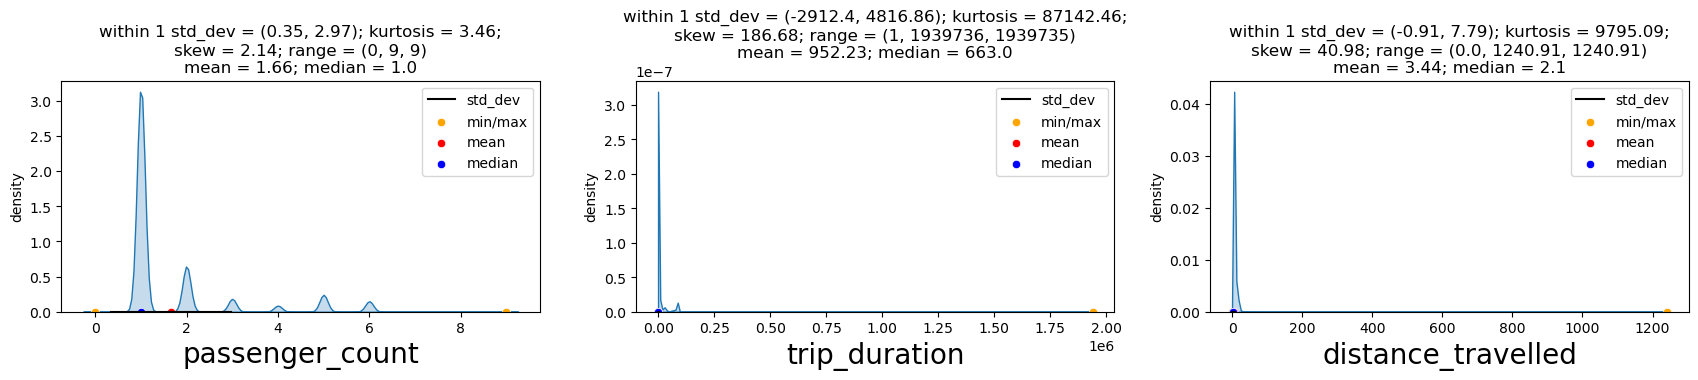

In [31]:
UVA_numeric(data,numeric_columns)

In [32]:
# standard deviation factor
factor = 3
# copying current_month
cm_data = data[numeric_columns[1:]]
# filtering using standard deviation (not considering obseravtions > 3* standard deviation)
cm_data = cm_data[cm_data['trip_duration'] < cm_data['trip_duration'].mean() + factor*cm_data['trip_duration'].std()]
cm_data = cm_data[cm_data['distance_travelled'] < cm_data['distance_travelled'].mean() + factor*cm_data['distance_travelled'].std()]
# checking how many points removed
len(data), len(cm_data)

(729322, 708690)

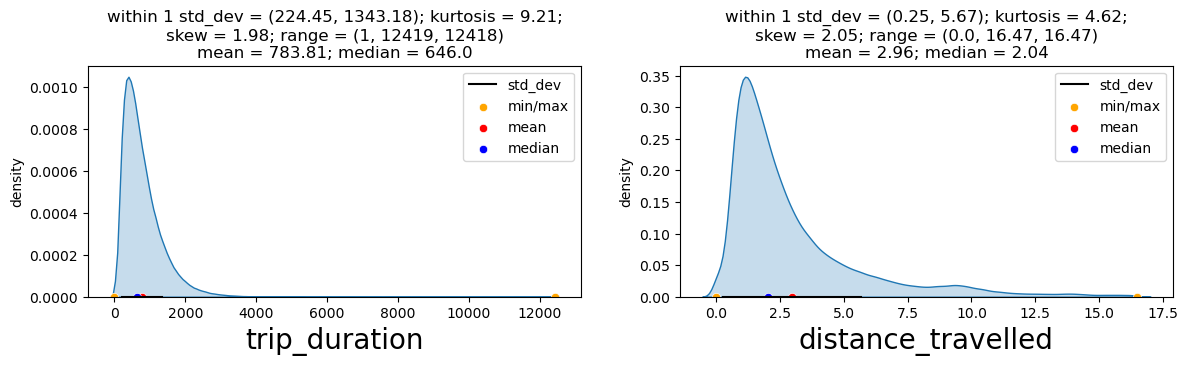

In [33]:
UVA_numeric(cm_data,numeric_columns[1:])

After treating outliers/extreme points skewness and kurtosis are within acceptable range of [-3,3] and [-10,10]. For the acceptable range of skewness and kurtosis refer to https://www.sciencedirect.com/topics/neuroscience/kurtosis The above plots are right skewed

Analyzing the above plots give us the following
- The trip duration preferred by majority of customers is around 10-12 mins
- The distance travelled preferred by majority of customers is around 2km
- Majority trips have single passenger

In [34]:
# custom function for easy outlier analysis

def UVA_outlier(data, var_group, include_outlier = True):
  '''
  Univariate_Analysis_outlier:
  takes a group of variables (INTEGER and FLOAT) and plot/print boplot and descriptives\n
  Runs a loop: calculate all the descriptives of i(th) variable and plot/print it \n\n

  data : dataframe from which to plot from\n
  var_group : {list} type Group of Continuous variables\n
  include_outlier : {bool} whether to include outliers or not, default = True\n
  '''

  size = len(var_group)
  plt.figure(figsize = (7*size,4), dpi = 100)
  
  #looping for each variable
  for j,i in enumerate(var_group):
    
    # calculating descriptives of variable
    quant25 = data[i].quantile(0.25)
    quant75 = data[i].quantile(0.75)
    IQR = quant75 - quant25
    med = data[i].median()
    whis_low = med-(1.5*IQR)
    whis_high = med+(1.5*IQR)

    # Calculating Number of Outliers
    outlier_high = len(data[i][data[i]>whis_high])
    outlier_low = len(data[i][data[i]<whis_low])

    if include_outlier == True:
      print(include_outlier)
      #Plotting the variable with every information
      plt.subplot(1,size,j+1)
      sns.boxplot(data[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('With Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))
      
    else:
      # replacing outliers with max/min whisker
      data2 = data[var_group][:]
      data2[i][data2[i]>whis_high] = whis_high+1
      data2[i][data2[i]<whis_low] = whis_low-1
      
      # plotting without outliers
      plt.subplot(1,size,j+1)
      sns.boxplot(data2[i], orient="v")
      plt.ylabel('{}'.format(i))
      plt.title('Without Outliers\nIQR = {}; Median = {} \n 2nd,3rd  quartile = {};\n Outlier (low/high) = {} \n'.format(
                                                                                                   round(IQR,2),
                                                                                                   round(med,2),
                                                                                                   (round(quant25,2),round(quant75,2)),
                                                                                                   (outlier_low,outlier_high)
                                                                                                   ))

True
True
True


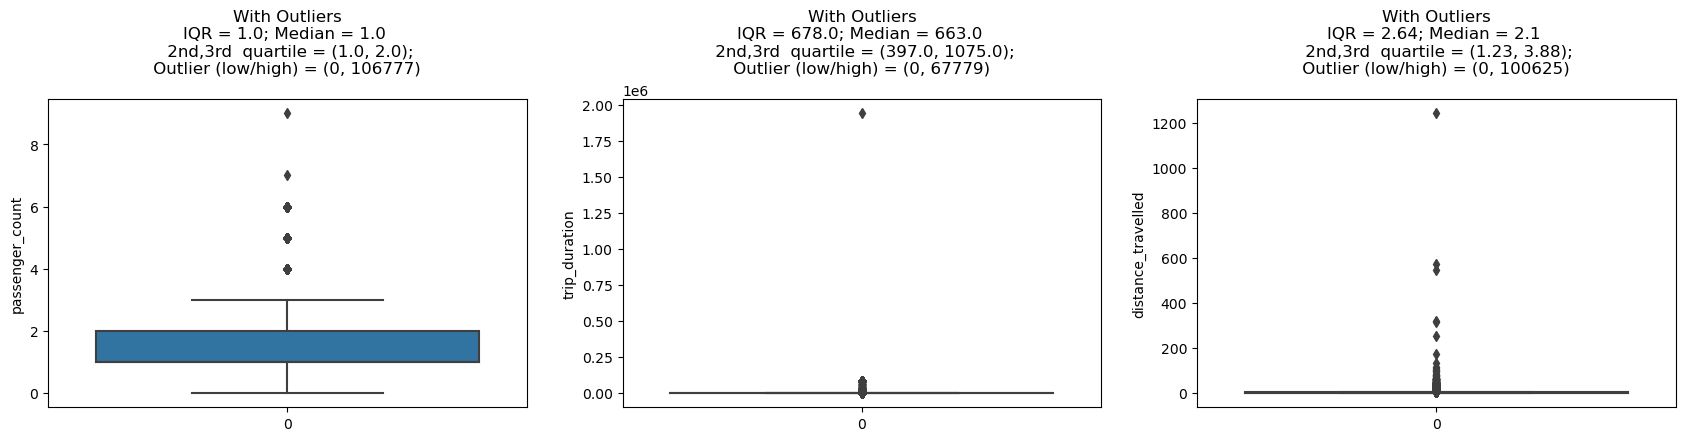

In [35]:
UVA_outlier(data,numeric_columns)

Many outliers are present for <b>trip_duration</b> and <b>distance_travelled features</b>. We would remove the outliers and analyze them further

C:\Users\sumeet\AppData\Local\Temp\ipykernel_28140\2083382972.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[i][data2[i]<whis_low] = whis_low-1
C:\Users\sumeet\AppData\Local\Temp\ipykernel_28140\2083382972.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2[i][data2[i]<whis_low] = whis_low-1


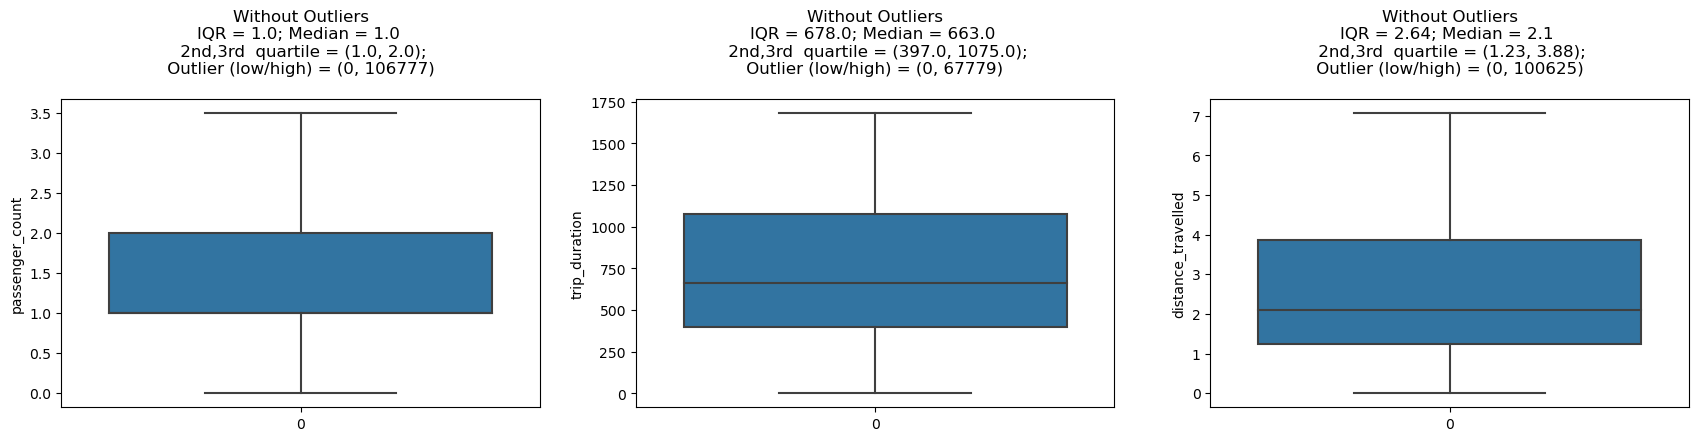

In [36]:
UVA_outlier(data,numeric_columns,include_outlier=False)

Outliers are significant in number for trip_duration and distance_travelled attributes and similar in number which indicates some inherent undiscovered behviour of Outliers.

In [37]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format
    

def UVA_category(data, var_group):

  '''
  Univariate_Analysis_categorical
  takes a group of variables (category) and plot/print all the value_counts and barplot.
  '''
  # setting figure_size
  size = len(var_group)
  plt.figure(figsize = (9*size,10), dpi = 100)

  # for every variable
  for j,i in enumerate(var_group):
    a=j+1
    norm_count = data[i].value_counts(normalize = True)
    n_uni = data[i].nunique()
    s = data[i].value_counts()
  #Plotting the variable with every information
    plt.subplot(a,size*2,j+1)
    sns.barplot(x=norm_count, y=norm_count.index , order = norm_count.index)
    plt.xlabel('fraction/percent', fontsize = 10)
    plt.ylabel('{}'.format(i), fontsize = 10)
    plt.title('n_uniques = {} \n value counts \n {};'.format(n_uni,norm_count))
    if s.shape[0] <=7:
        plt.subplot(a,size*2,j+3)
        s.plot.pie(autopct=autopct_format(s))
    a+=2

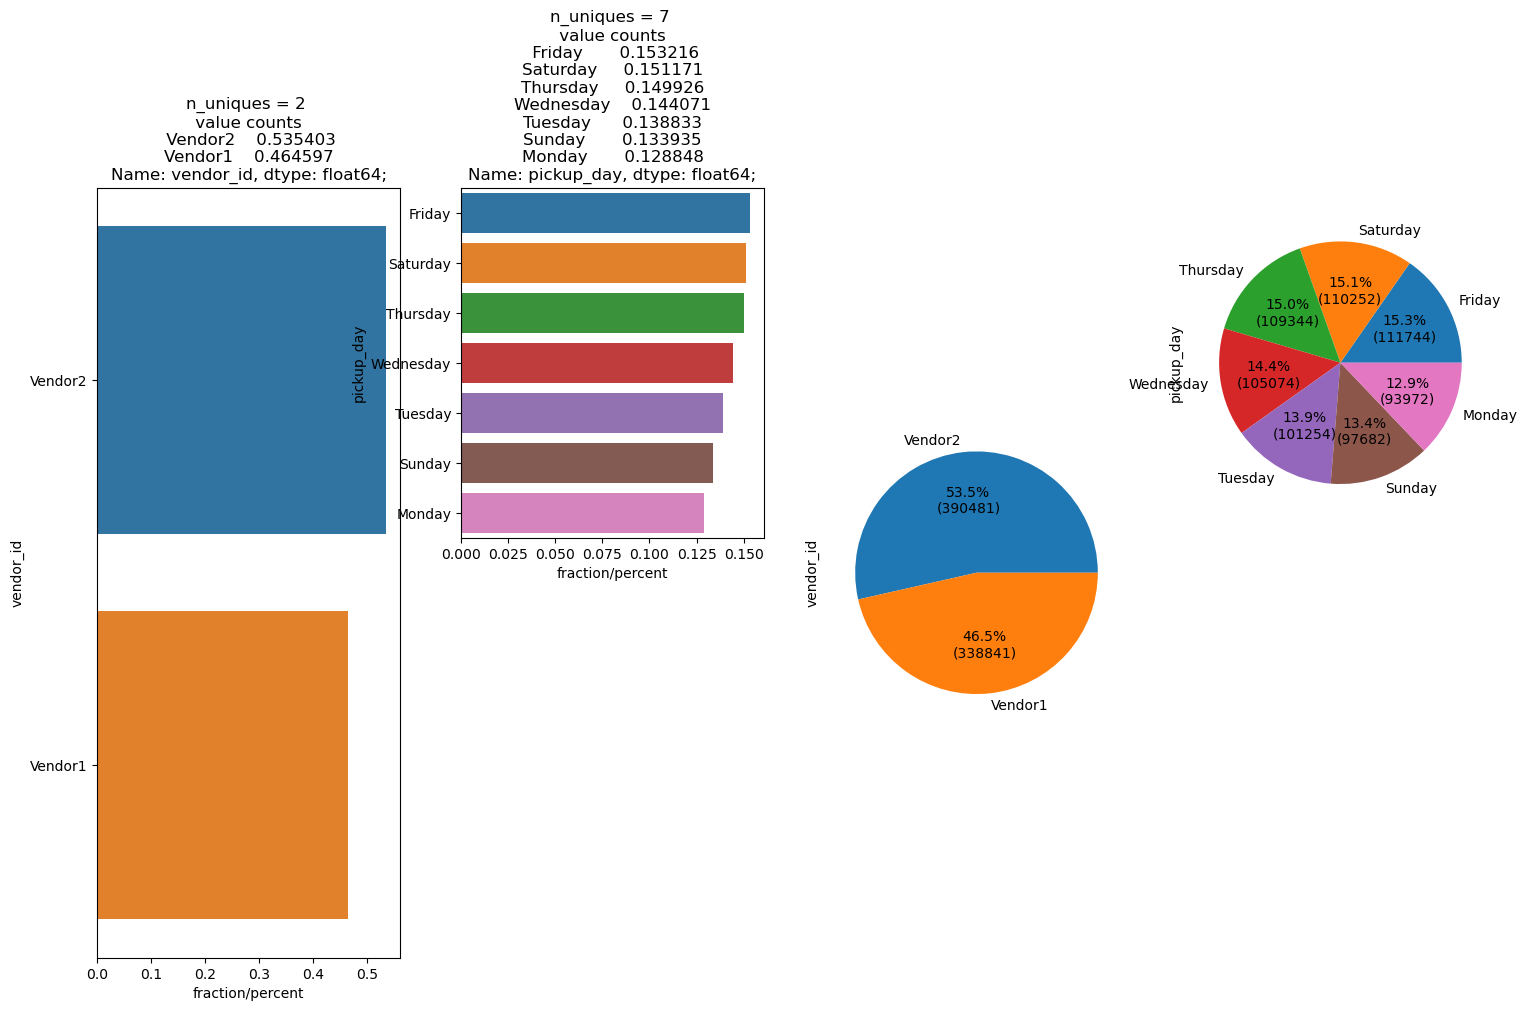

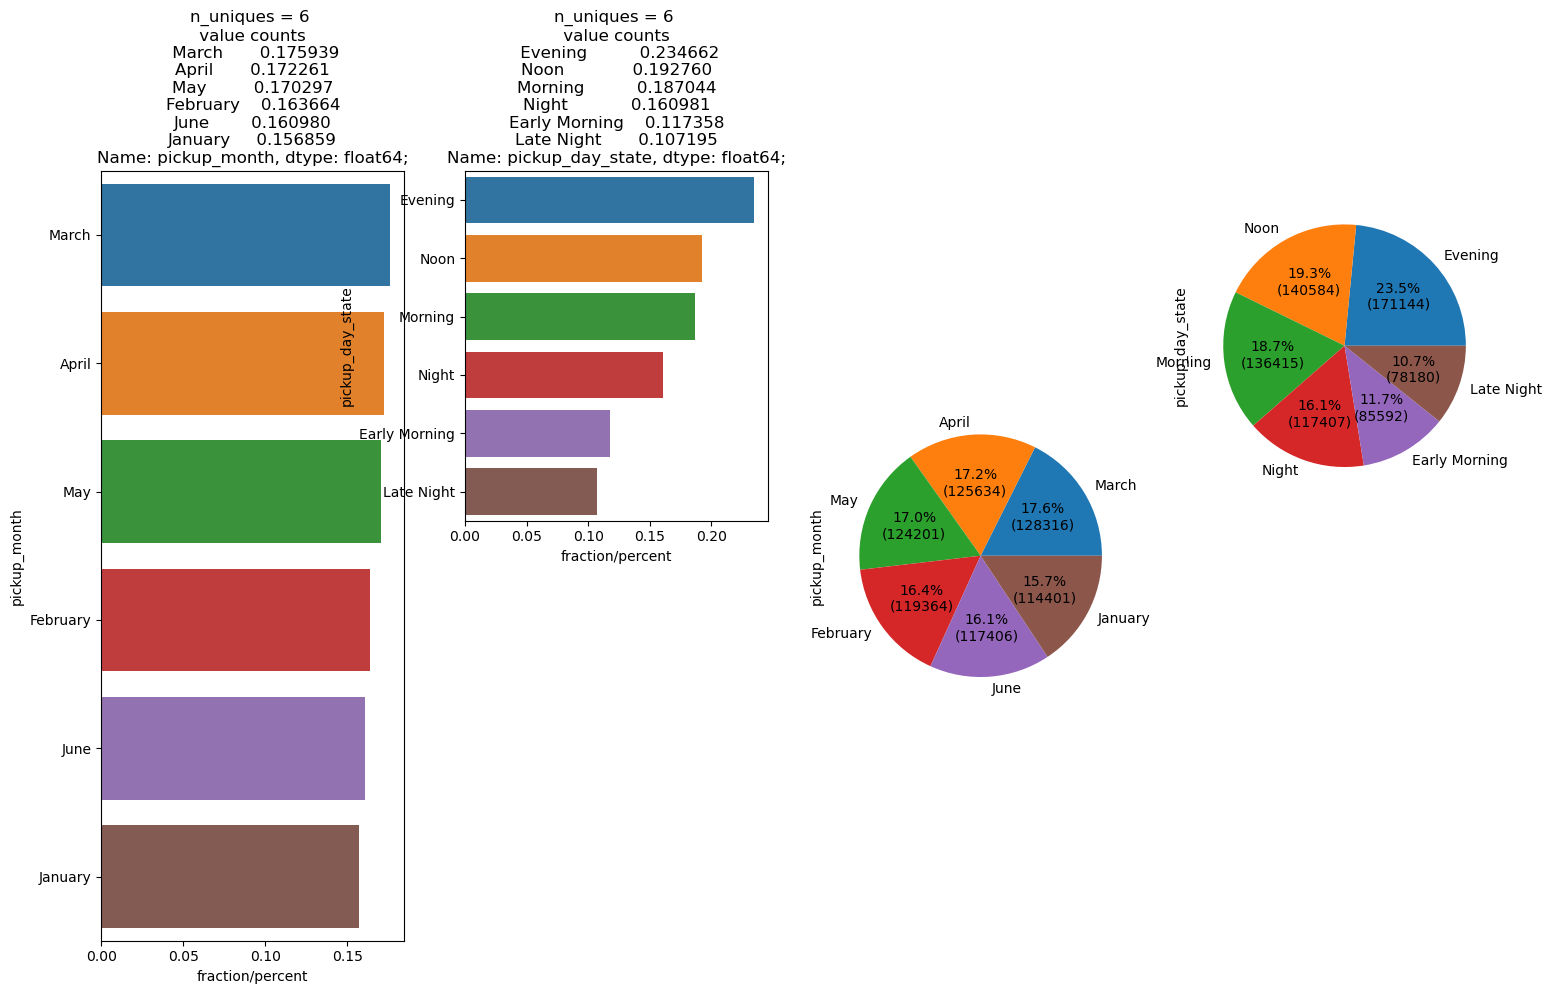

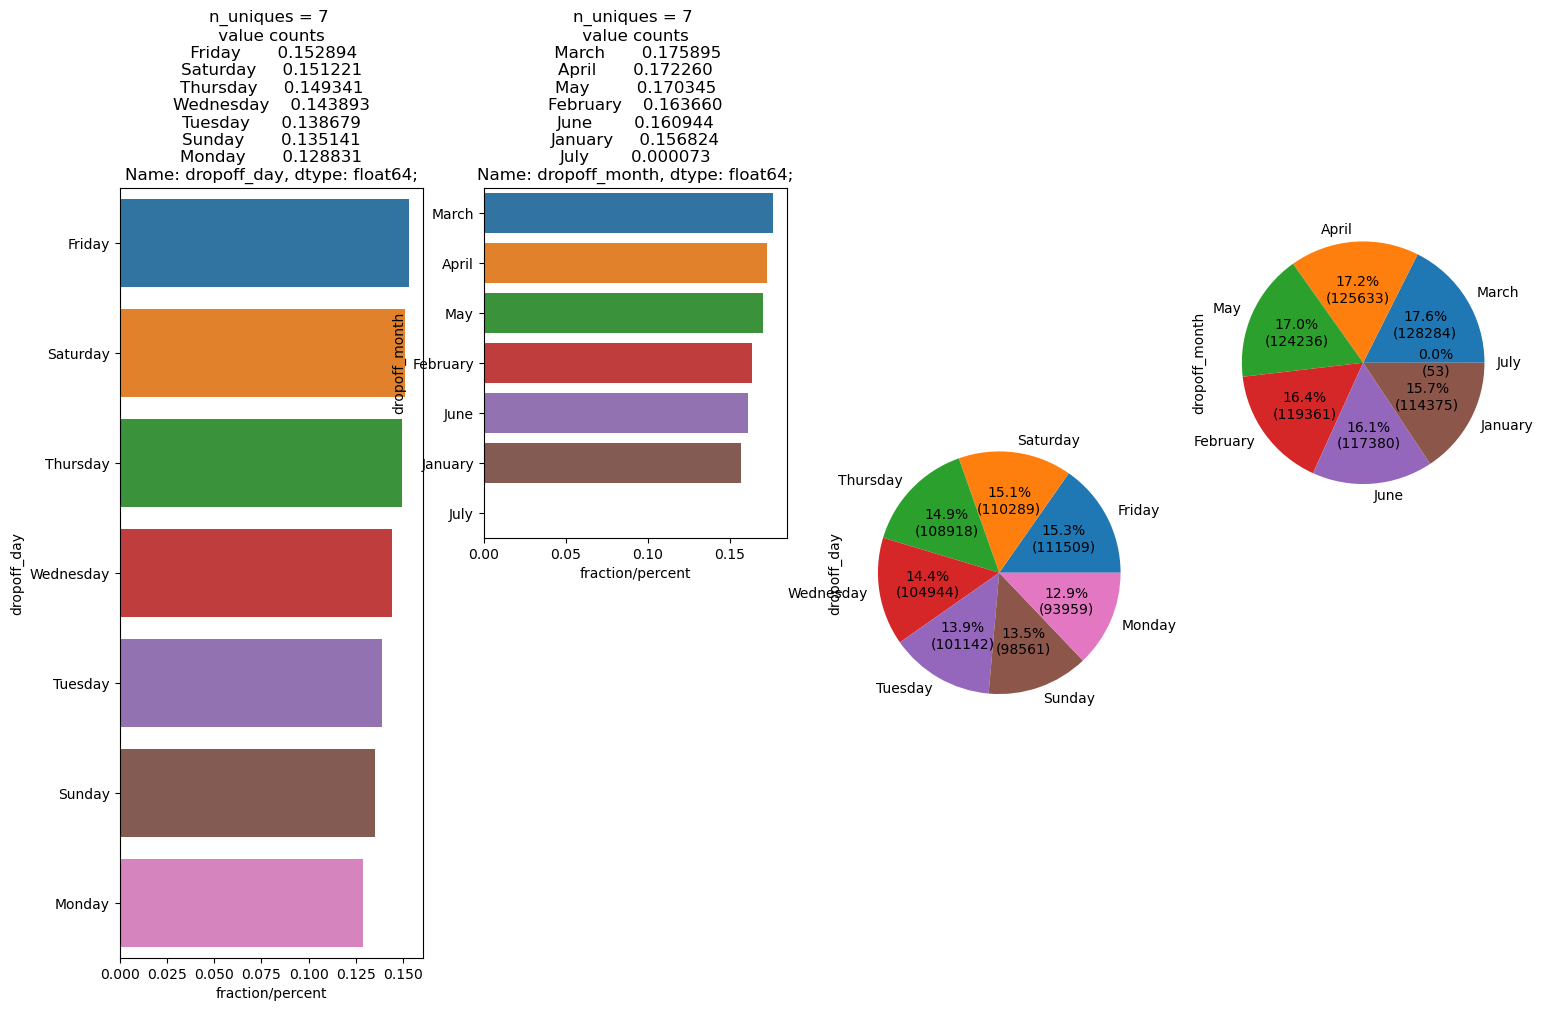

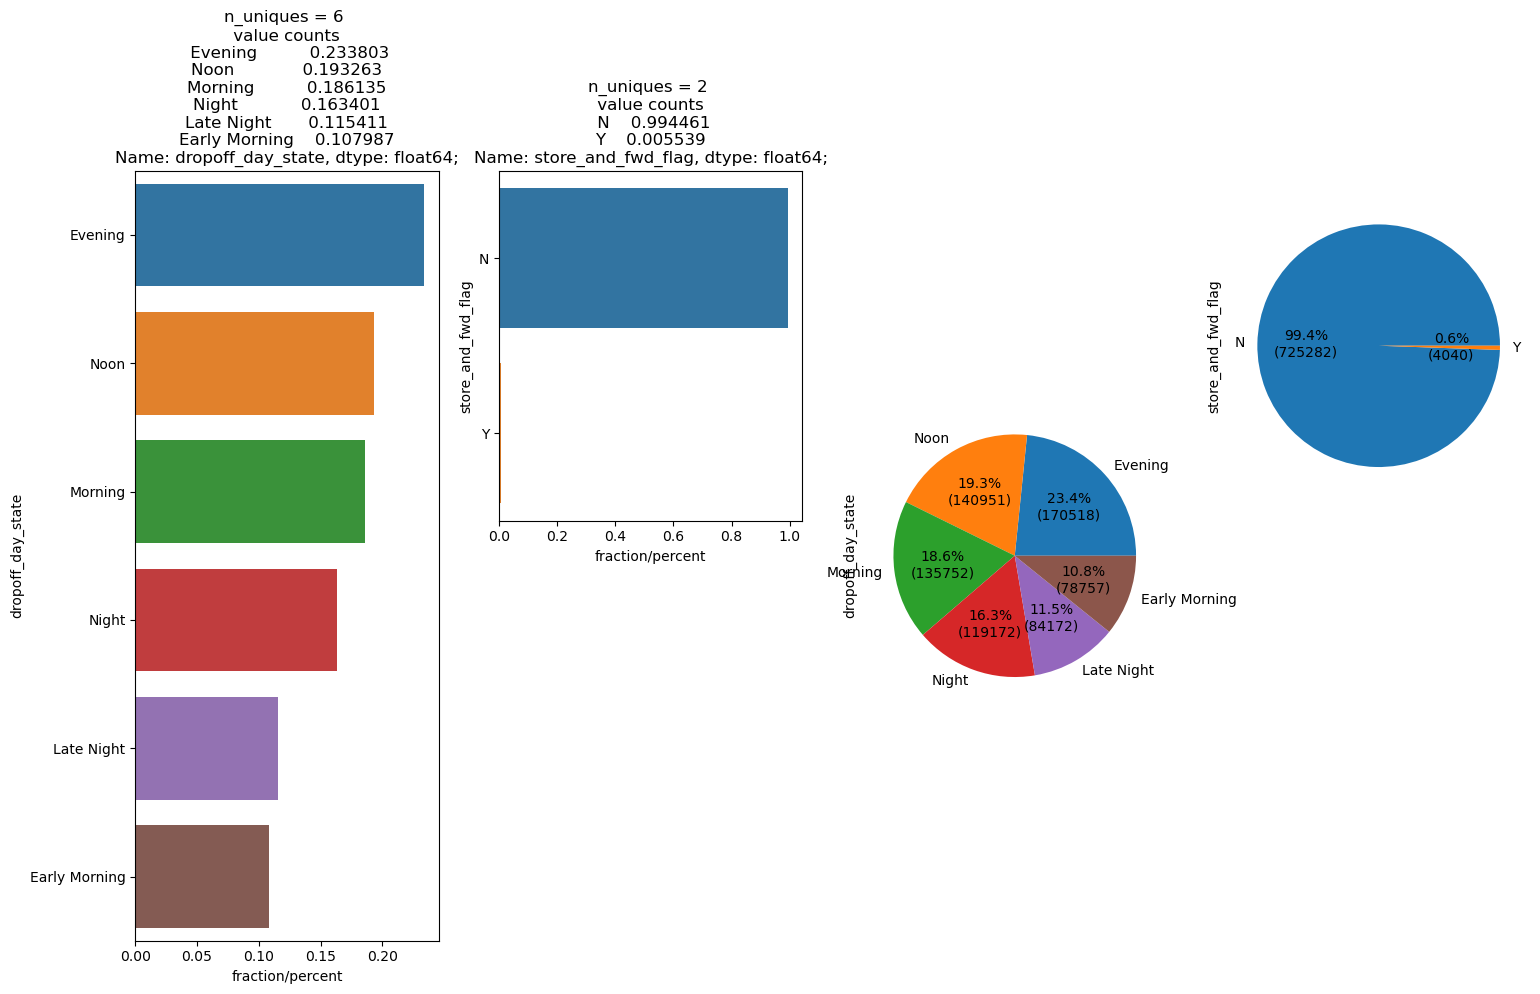

In [38]:
cat_index_split = [(i,i+2) for i in range(0,len(categorical_columns),2)]
for i in cat_index_split:
    UVA_category(data,categorical_columns[i[0]:i[1]])

From the above analysis of the categorical variables, we can infer the following
- Mostly the trip information is not stored as <b>store_and_fwd_flag</b> is N
- Most of the trips are taken during Friday closely followed by Saturday and Thursday
- Most of the trips are taken during Evening followed by Noon and Morning while Late Night and Early Morning trips are relatively less
- <b>Vendor 2</b> has more trips compared to <b>Vendor 1</b>
- Most number of trips are happening in the month of March closely followed by April and May

#### Bivariate Analysis

<b>Heatmap</b>

C:\Users\sumeet\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:5283: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


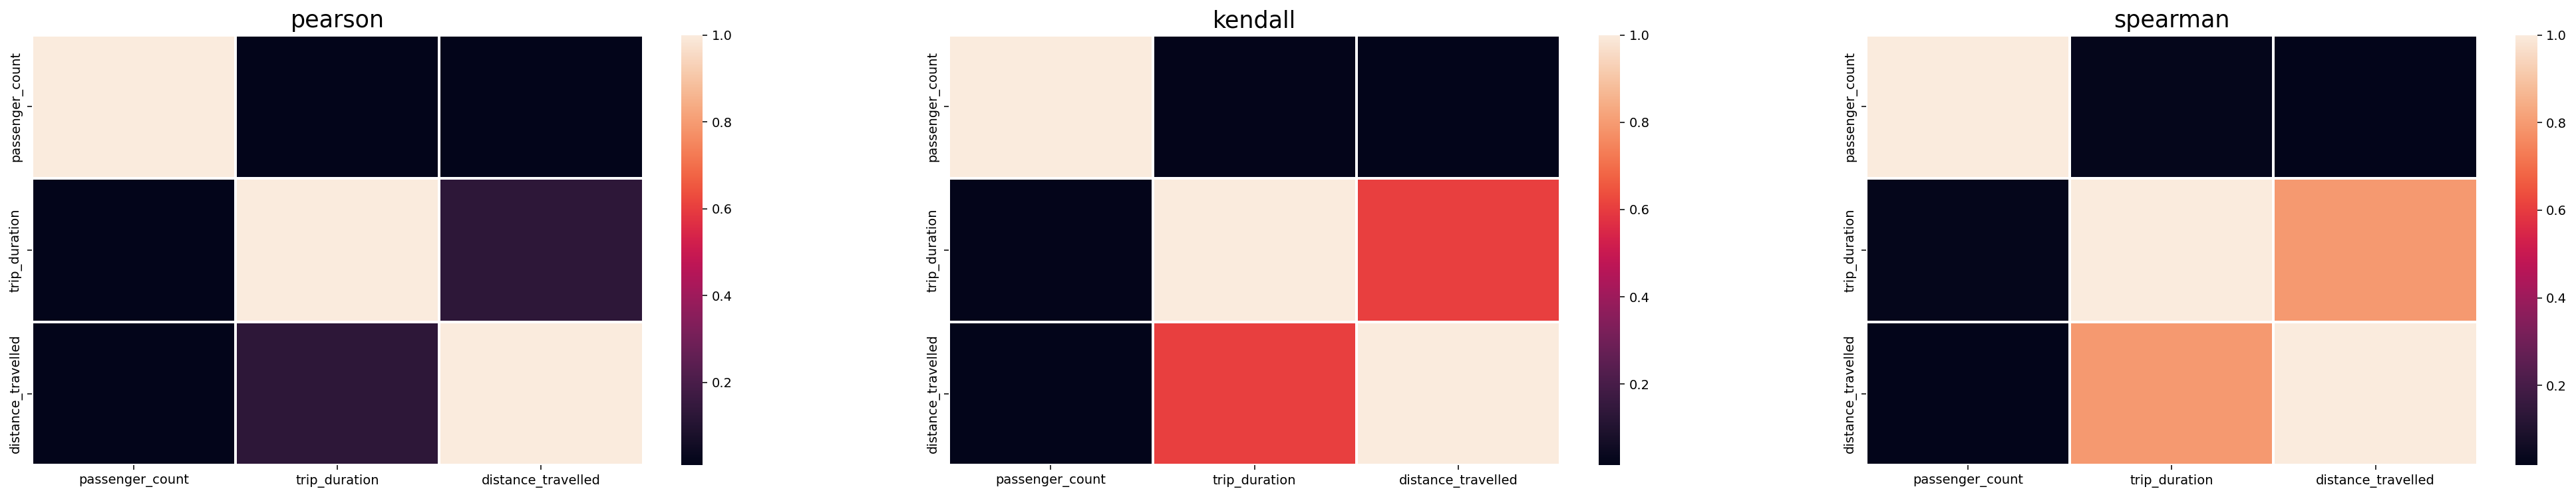

In [39]:
plt.figure(figsize=(36,6), dpi=140)
numerical = data[numeric_columns]
for j,i in enumerate(['pearson','kendall','spearman']):
  plt.subplot(1,3,j+1)
  correlation = numerical.corr(method=i)
  sns.heatmap(correlation, linewidth = 2)
  plt.title(i, fontsize=18)

From the above correlation plots, we observe <b>kendall</b> and <b>spearman methods</b> are giving more or less similar results. Also <b>trip_duration</b> and <b>distance_travelled</b> features are highly correlated with each other. However, <b>passenger_count</b> has insignificant or no correlation with <b>trip_duration</b> and <b>distance_travelled</b> features

<b>Scatter Plot</b>

In [40]:
for column in numeric_columns:
  mini=1
  if numerical[column].min()<0:
    mini =  abs(numerical[column].min()) + 1
  
  numerical[column] = [i+mini for i in numerical[column]]
  numerical[column] = numerical[column].map(lambda x : np.log(x))

C:\Users\sumeet\AppData\Local\Temp\ipykernel_28140\295711233.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical[column] = [i+mini for i in numerical[column]]
C:\Users\sumeet\AppData\Local\Temp\ipykernel_28140\295711233.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical[column] = numerical[column].map(lambda x : np.log(x))


<Axes: xlabel='passenger_count', ylabel='distance_travelled'>

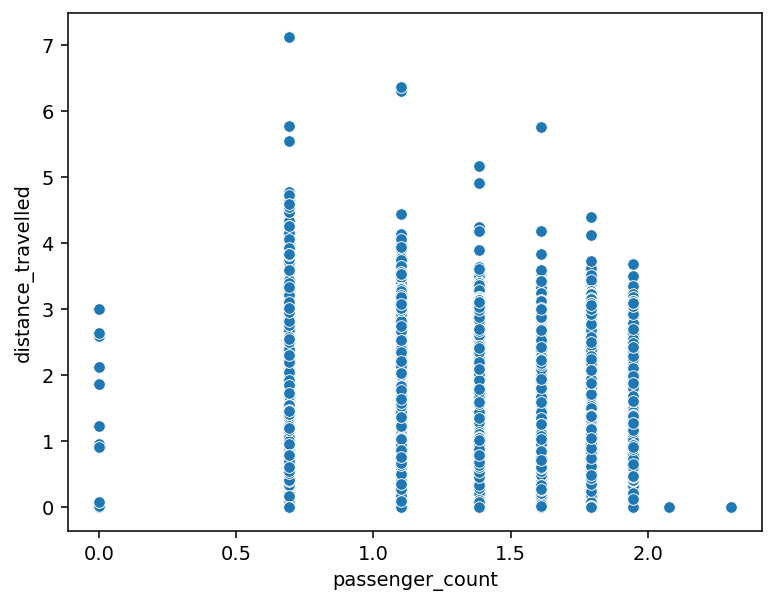

In [41]:
plt.figure(dpi=140)
sns.scatterplot(x=numerical['passenger_count'], y=numerical['distance_travelled'])

<Axes: xlabel='passenger_count', ylabel='trip_duration'>

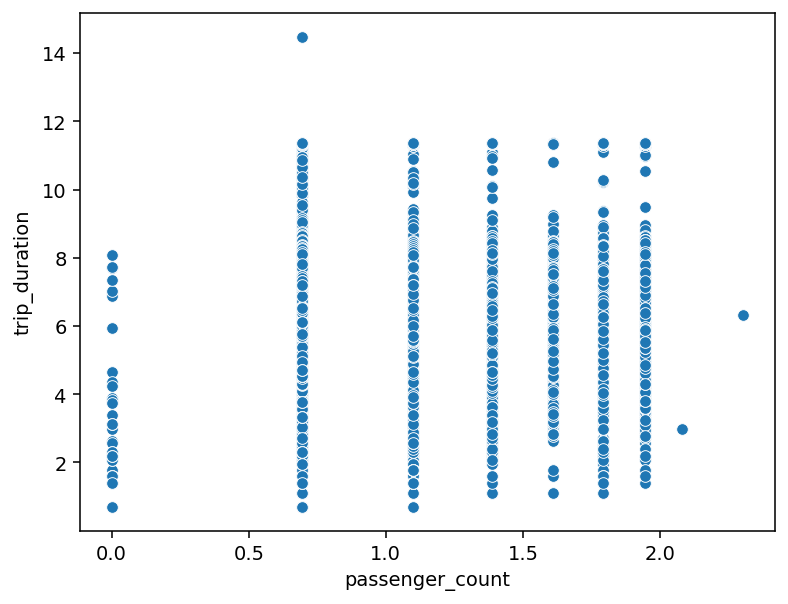

In [42]:
plt.figure(dpi=140)
sns.scatterplot(x=numerical['passenger_count'], y=numerical['trip_duration'])

<Axes: xlabel='trip_duration', ylabel='distance_travelled'>

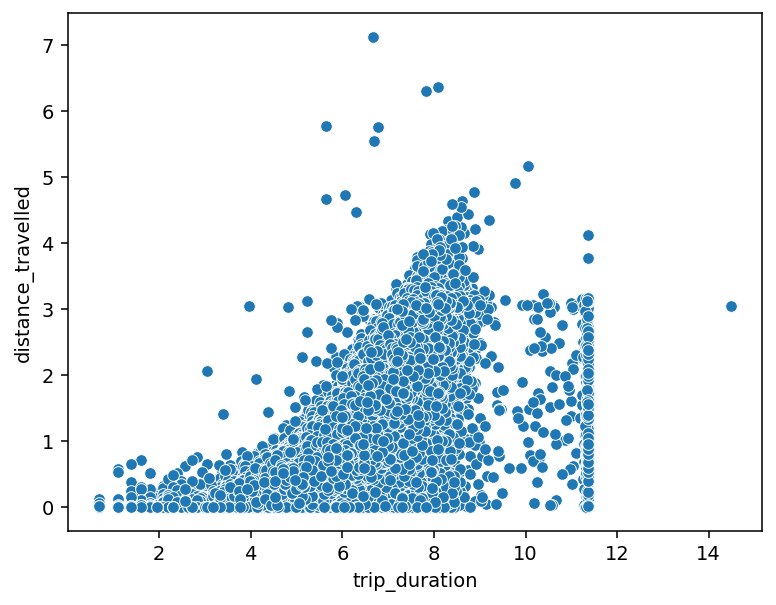

In [43]:
plt.figure(dpi=140)
sns.scatterplot(x=numerical['trip_duration'], y=numerical['distance_travelled'])

From the above scatter plots, we can conclude that <b>trip_duration</b> and <b>distance_travelled</b> features are highly correlated with each other. However, <b>passenger_count</b> has insignificant or no correlation with <b>trip_duration</b> and <b>distance_travelled features</b>

<b>Analyzing categorical variables with continuous target variable<b>

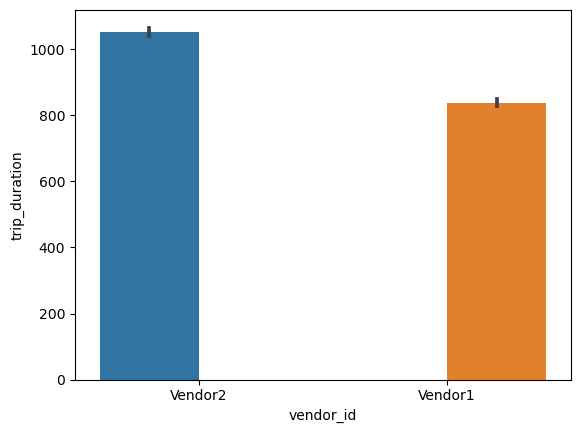

In [44]:
ax = sns.barplot(data=data, x=categorical_columns[0], y="trip_duration",hue=categorical_columns[0])
ax.legend_.remove()

From the above plot we infer that Vendor2 has more average <b>trip_duration</b> than Vendor1

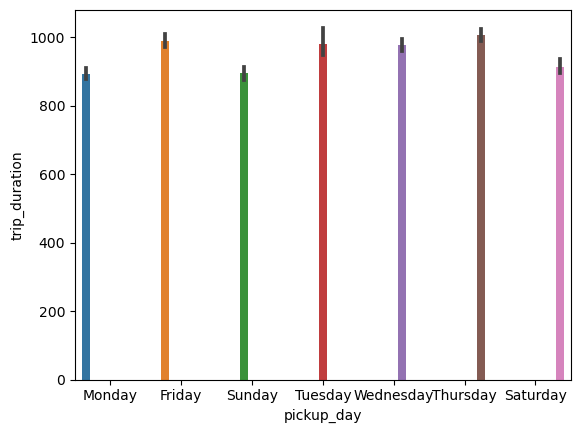

In [45]:
ax = sns.barplot(data=data, x=categorical_columns[1], y="trip_duration",hue=categorical_columns[1])
ax.legend_.remove()

From the above plot we infer that the <b>pickup_day</b> Thursday has the highest average <b>trip_duration</b> closely followed by <b>pickup_day</b> Friday 

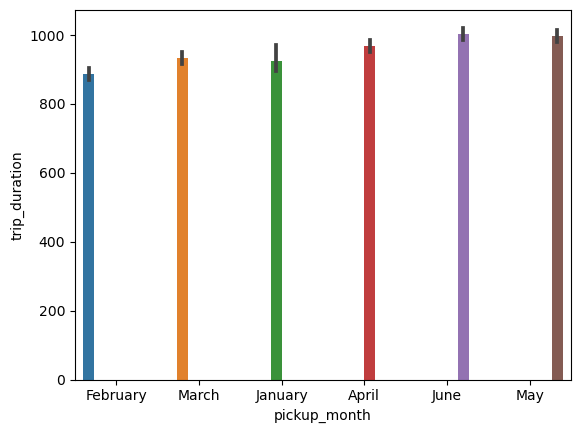

In [46]:
ax = sns.barplot(data=data, x=categorical_columns[2], y="trip_duration",hue=categorical_columns[2])
ax.legend_.remove()

From the above plot we infer that the <b>pickup_month</b> June has the highest average <b>trip_duration</b> closely followed by <b>pickup_month</b> May 

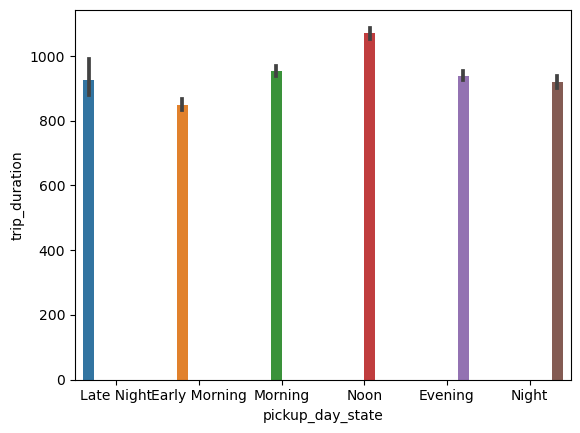

In [47]:
ax = sns.barplot(data=data, x=categorical_columns[3], y="trip_duration",hue=categorical_columns[3])
ax.legend_.remove()

From the above plot we infer that the <b>pickup_day_state</b> Noon has the highest average <b>trip_duration</b> followed by <b>pickup_day_state</b> Morning

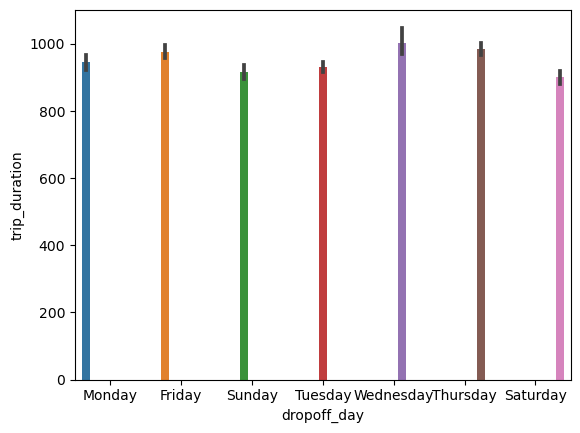

In [48]:
ax = sns.barplot(data=data, x=categorical_columns[4], y="trip_duration",hue=categorical_columns[4])
ax.legend_.remove()

From the above plot we infer that the <b>dropoff_day</b> Wednesday has the highest average <b>trip_duration</b> closely followed by <b>dropoff_day</b> Thursday

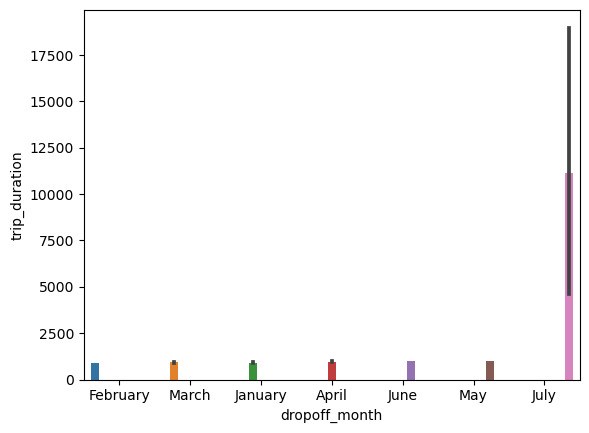

In [49]:
ax = sns.barplot(data=data, x=categorical_columns[5], y="trip_duration",hue=categorical_columns[5])
ax.legend_.remove()

From the above plot we infer that the <b>dropoff_month</b> July has the highest average <b>trip_duration</b> and for rest of the months it is more or less the same. This suggests the presence of an outlier for the given <b>dropoff_month</b> 

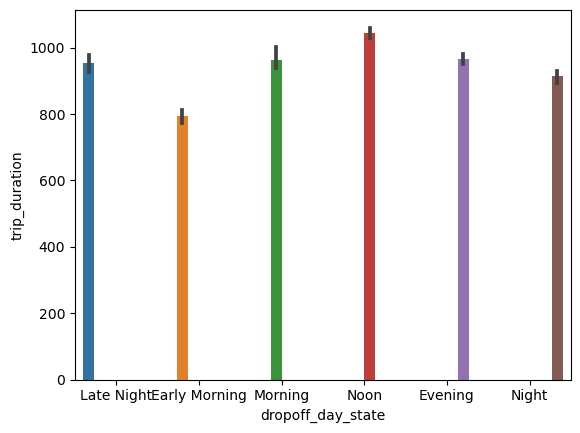

In [50]:
ax = sns.barplot(data=data, x=categorical_columns[6], y="trip_duration",hue=categorical_columns[6])
ax.legend_.remove()

From the above plot we infer that the <b>dropoff_day_state</b> Noon has the highest average <b>trip_duration</b> followed by <b>dropoff_day_state</b> Morning, Evening and Late Night

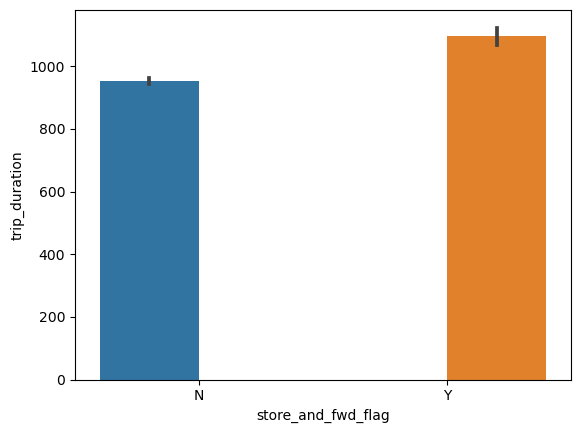

In [51]:
ax = sns.barplot(data=data, x=categorical_columns[7], y="trip_duration",hue=categorical_columns[7])
ax.legend_.remove()

From the above plot we infer that average <b>trip_duration</b> is highest when <b>store_and_fwd_flag</b> is Y

#### We will conduct Kruskal-Wallis-H test which is non-parametric statistical test @ 5% significance level

In [52]:
import scipy.stats as stats
def check_hypothesis(p_value):
    Decision = {True : f"p-value({p_value}) < 0.05, Reject Null hypothesis",
                False : f"p-value({p_value}) > 0.05, Failed to reject Null hypothesis"}
    return Decision[p_value < 0.05]
for i in categorical_columns:
    values_arr = list(data.groupby(i, as_index=False)['trip_duration'].agg({'list':(lambda x: list(x))})['list'].values)
    test_stat, p_value = stats.kruskal(*values_arr)
    print(f"H0 : Trip Duration is independent of {i}")
    print(f"H1 : Trip Duration is not independent of {i}")
    print(f'{i} p_value: {p_value}')
    print(check_hypothesis(p_value))
    print()

H0 : Trip Duration is independent of vendor_id
H1 : Trip Duration is not independent of vendor_id
vendor_id p_value: 3.4002252613499733e-16
p-value(3.4002252613499733e-16) < 0.05, Reject Null hypothesis

H0 : Trip Duration is independent of pickup_day
H1 : Trip Duration is not independent of pickup_day
pickup_day p_value: 0.0
p-value(0.0) < 0.05, Reject Null hypothesis

H0 : Trip Duration is independent of pickup_month
H1 : Trip Duration is not independent of pickup_month
pickup_month p_value: 0.0
p-value(0.0) < 0.05, Reject Null hypothesis

H0 : Trip Duration is independent of pickup_day_state
H1 : Trip Duration is not independent of pickup_day_state
pickup_day_state p_value: 0.0
p-value(0.0) < 0.05, Reject Null hypothesis

H0 : Trip Duration is independent of dropoff_day
H1 : Trip Duration is not independent of dropoff_day
dropoff_day p_value: 0.0
p-value(0.0) < 0.05, Reject Null hypothesis

H0 : Trip Duration is independent of dropoff_month
H1 : Trip Duration is not independent of d

Running the above statistical test gives the following:
- <b>trip_duration</b> is dependent on <b>vendor_id</b>, <b>pickup_day</b>, <b>pickup_month</b>, <b>pickup_day_state</b>, <b>dropoff_day</b>, <b>dropoff_month</b>, <b>dropoff_day_state</b> and <b>store_and_fwd_flag</b>

<b>Categorical v/s Categorical Variable Analysis</b>

We will use Chi square contingency test to establish independence/dependence between two categorical variables

In [53]:
def chi_square_test(col1,col2):
  data1 = data[[col1,col2]][:]
  #forming a crosstab
  table = pd.crosstab(data1[col2],data1[col1],)
  f_obs = np.array([table.iloc[0][:].values,
                    table.iloc[1][:].values])

  check = data.groupby(col1)[col2].value_counts(normalize=True).unstack()
  if check.isnull().values.any():
      print(f"{col1} and {col2} violate chi2_contingency test assumptions")
      return
  #performing chi2 test
  from scipy.stats import chi2_contingency
  try:
      chi, p, dof, expected = chi2_contingency(f_obs)
  except Exception as e:
      print(f"{col1} and {col2} violate chi2_contingency test assumptions")
      return
  
  #checking whether results are significant
  if p<0.05:
    sig = True
  else:
    sig = False
  print(f"p value is {p}")
  if sig:
    print(f"There is a relationship between {col1} and {col2}")
  else:
    print(f"There is no relationship between {col1} and {col2}")

In [54]:
from itertools import combinations
cat_pairs = list(combinations(categorical_columns,2))
for category1,category2 in cat_pairs:
    chi_square_test(category1,category2)
    print()

p value is 0.27307682754348517
There is no relationship between vendor_id and pickup_day

p value is 0.0036175513427539195
There is a relationship between vendor_id and pickup_month

p value is 1.0
There is no relationship between vendor_id and pickup_day_state

p value is 0.2901111336158002
There is no relationship between vendor_id and dropoff_day

p value is 0.0038602784374711487
There is a relationship between vendor_id and dropoff_month

p value is 0.32930334387349447
There is no relationship between vendor_id and dropoff_day_state

vendor_id and store_and_fwd_flag violate chi2_contingency test assumptions

p value is 8.00406269087169e-252
There is a relationship between pickup_day and pickup_month

p value is 0.0
There is a relationship between pickup_day and pickup_day_state

pickup_day and dropoff_day violate chi2_contingency test assumptions

pickup_day and dropoff_month violate chi2_contingency test assumptions

p value is 0.0
There is a relationship between pickup_day and dr

From the above results, we can infer that there are some relationships between the categorical variables and this information will be useful when we perform feature engineering. The pair of features (<b>pickup_day</b>, <b>dropoff_day</b>), (<b>vendor_id</b>, <b>store_and_fwd_flag</b>), (<b>dropoff_month</b>, <b>store_and_fwd_flag</b>), (<b>pickup_day</b>, <b>dropoff_month</b>), (<b>dropoff_day</b>, <b>dropoff_month</b>), (<b>pickup_day_state</b>, <b>dropoff_month</b>) and (<b>pickup_month</b>, <b>dropoff_month</b>) which violate chi_square contingency test assumptions are independent of each other

Let us look at some of the dependencies obtained from the above and validate the same using stacked bar plot visualization

Vendor_Id v/s Pickup_Month

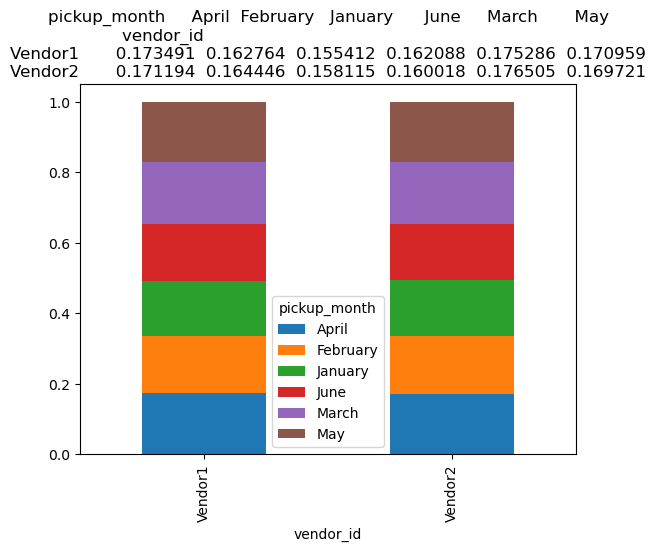

In [55]:
ax1 = data.groupby('vendor_id')['pickup_month'].value_counts(normalize=True).unstack()
s = ax1.plot(kind='bar', stacked='True',title=str(ax1))

Pickup_Day_State v/s DropOff_Day_State

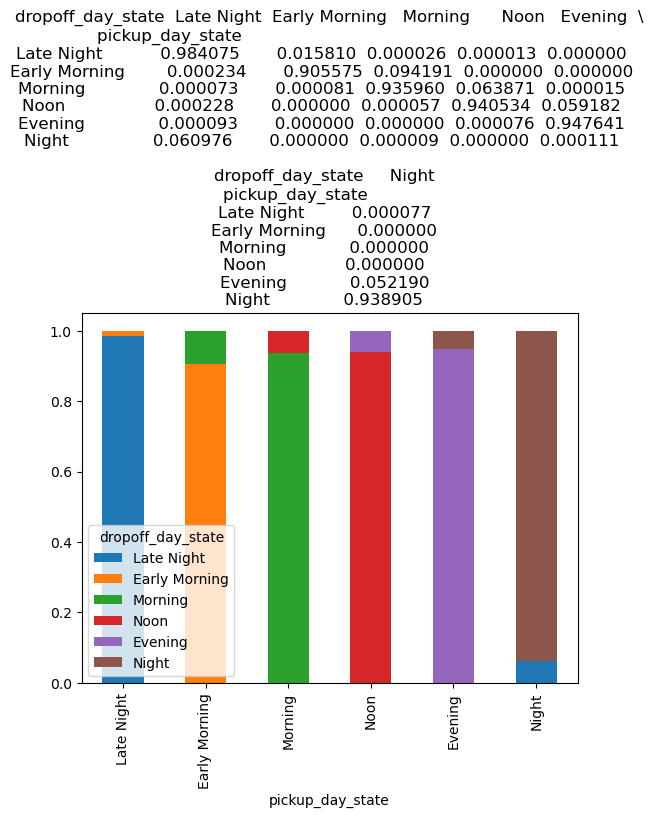

In [56]:
ax1 = data.groupby('pickup_day_state')['dropoff_day_state'].value_counts(normalize=True).unstack()
s = ax1.plot(kind='bar', stacked='True',title=str(ax1))

Vendor_Id v/s DropOff_Month

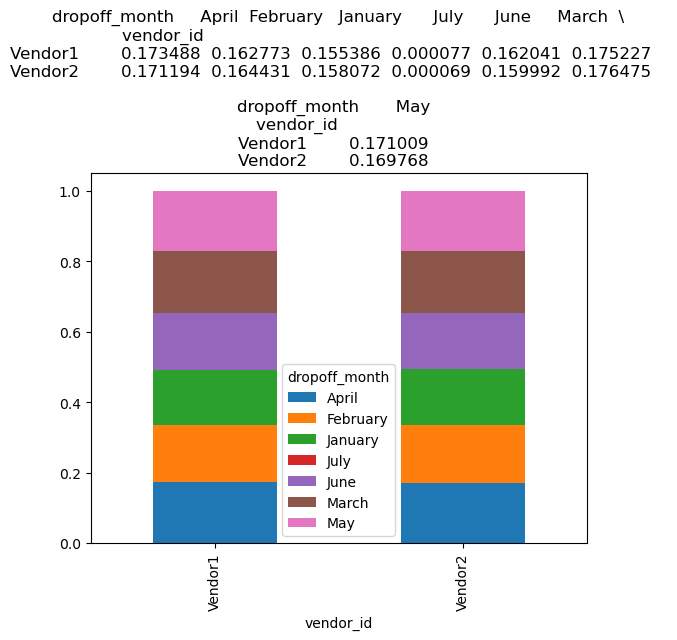

In [57]:
ax1 = data.groupby('vendor_id')['dropoff_month'].value_counts(normalize=True).unstack()
s = ax1.plot(kind='bar', stacked='True',title=str(ax1))

Analyzing the above visualizations verifies the results obtained from Chi square contingency test

#### Multivariate Analysis

In [58]:
df = data.pivot_table('trip_duration', ['vendor_id', 'store_and_fwd_flag'], 'pickup_day_state', aggfunc='mean')
df

pickup_day_state               Late Night  Early Morning      Morning  \
vendor_id store_and_fwd_flag                                            
Vendor1   N                    786.592825     743.721143   855.890317   
          Y                    861.613757    1071.364269  1084.620828   
Vendor2   N                   1050.556611     941.661120  1034.976679   

pickup_day_state                     Noon      Evening        Night  
vendor_id store_and_fwd_flag                                         
Vendor1   N                    932.606988   829.585936   794.578242  
          Y                   1382.391211  1033.197466   922.239203  
Vendor2   N                   1187.732233  1029.827763  1025.539042

In [59]:
df.max()

pickup_day_state
Late Night       1050.556611
Early Morning    1071.364269
Morning          1084.620828
Noon             1382.391211
Evening          1033.197466
Night            1025.539042
dtype: float64

From the above, we observe the average <b>trip_duration</b> is maximum when <b>pickup_day_state</b> is <b>Noon</b> followed by <b>Morning</b> and <b>Early Morning</b>

In [60]:
df = data.pivot_table('passenger_count', ['vendor_id', 'store_and_fwd_flag'], 'pickup_day_state', aggfunc='sum')
df

pickup_day_state              Late Night  Early Morning  Morning    Noon  \
vendor_id store_and_fwd_flag                                               
Vendor1   N                        48403          45264    74913   83831   
          Y                          495            506      967    1232   
Vendor2   N                        84111          89183   148749  150067   
          Y                            0              0        0       0   

pickup_day_state              Evening   Night  
vendor_id store_and_fwd_flag                   
Vendor1   N                     98732   70043  
          Y                      1243     787  
Vendor2   N                    185730  127917  
          Y                         0       0

In [61]:
df.max()

pickup_day_state
Late Night        84111
Early Morning     89183
Morning          148749
Noon             150067
Evening          185730
Night            127917
dtype: int64

From the above, we observe the total <b>passenger_count</b> is maximum when <b>pickup_day_state</b> is <b>Evening</b> followed by <b>Noon</b> and <b>Morning</b>

In [62]:
df = data.pivot_table('distance_travelled', ['vendor_id', 'store_and_fwd_flag'], 'pickup_day_state', aggfunc='mean')
df

pickup_day_state              Late Night  Early Morning   Morning      Noon  \
vendor_id store_and_fwd_flag                                                  
Vendor1   N                     4.037584       3.447339  2.967172  3.321529   
          Y                     5.107694       5.556887  4.582359  5.941068   
Vendor2   N                     4.087221       3.643749  3.042036  3.424161   

pickup_day_state               Evening     Night  
vendor_id store_and_fwd_flag                      
Vendor1   N                   3.211643  3.738005  
          Y                   4.548317  4.783680  
Vendor2   N                   3.265465  3.783086

In [63]:
df.max()

pickup_day_state
Late Night       5.107694
Early Morning    5.556887
Morning          4.582359
Noon             5.941068
Evening          4.548317
Night            4.783680
dtype: float64

From the above, we observe the average <b>distance_travelled</b> is maximum when <b>pickup_day_state</b> is <b>Noon</b> closely followed by <b>Early Morning</b> and <b>Late Night</b>

In [64]:
df = data.pivot_table('trip_duration', ['vendor_id', 'store_and_fwd_flag'], ['pickup_day_state','dropoff_day_state'], aggfunc='mean')
df

pickup_day_state               Late Night                                    \
dropoff_day_state              Late Night Early Morning    Morning     Noon   
vendor_id store_and_fwd_flag                                                  
Vendor1   N                    725.981604   1141.910169  1939736.0  43235.0   
          Y                    849.780161   1744.400000        NaN      NaN   
Vendor2   N                   1035.627150   1147.953198    45507.0      NaN   

pickup_day_state                           Early Morning                \
dropoff_day_state                    Night    Late Night Early Morning   
vendor_id store_and_fwd_flag                                             
Vendor1   N                            NaN           NaN    682.990331   
          Y                            NaN           NaN    934.910761   
Vendor2   N                   83793.333333      64386.25    857.869670   

pickup_day_state                             Morning                ...  \
dropoff_day_state                 Morning Late Night Early Morning  ...   
vendor_id store_and_fwd_flag                                        ...   
Vendor1   N                   1343.294213        NaN           NaN  ...   
          Y                   2111.140000        NaN           NaN  ...   
Vendor2   N                   1436.495828    46003.3  83221.727273  ...   

pickup_day_state                     Noon                    Evening  \
dropoff_day_state                    Noon      Evening    Late Night   
vendor_id store_and_fwd_flag                                           
Vendor1   N                    886.672843  1684.831962  15377.500000   
          Y                   1258.924260  2567.954545           NaN   
Vendor2   N                   1125.858875  1785.976932  19466.142857   

pickup_day_state                                                      \
dropoff_day_state                     Noon      Evening        Night   
vendor_id store_and_fwd_flag                                           
Vendor1   N                            NaN   811.633953  1144.232786   
          Y                            NaN  1004.219756  1600.782609   
Vendor2   N                   82094.230769  1008.661807  1145.014776   

pickup_day_state                    Night                                     
dropoff_day_state              Late Night  Morning       Evening       Night  
vendor_id store_and_fwd_flag                                                  
Vendor1   N                   1214.178973  52376.0           NaN  765.930786  
          Y                   1338.720930      NaN           NaN  890.202147  
Vendor2   N                   1230.384052      NaN  83977.307692  994.336193  

[3 rows x 25 columns]

In [65]:
df.max()

pickup_day_state  dropoff_day_state
Late Night        Late Night           1.035627e+03
                  Early Morning        1.744400e+03
                  Morning              1.939736e+06
                  Noon                 4.323500e+04
                  Night                8.379333e+04
Early Morning     Late Night           6.438625e+04
                  Early Morning        9.349108e+02
                  Morning              2.111140e+03
Morning           Late Night           4.600330e+04
                  Early Morning        8.322173e+04
                  Morning              1.016650e+03
                  Noon                 1.812125e+03
                  Evening              2.482950e+04
Noon              Late Night           3.181344e+04
                  Morning              8.378388e+04
                  Noon                 1.258924e+03
                  Evening              2.567955e+03
Evening           Late Night           1.946614e+04
                  Noon      

From the above, we observe the average <b>trip_duration</b> is maximum when <b>pickup_day_state</b> is <b>Late Night</b> and <b>dropoff_day_state</b> is <b>Morning</b>

In [66]:
df =data.pivot_table('passenger_count', ['vendor_id', 'store_and_fwd_flag'], ['pickup_day_state','dropoff_day_state'], aggfunc='sum')
df

pickup_day_state             Late Night                                     \
dropoff_day_state            Late Night Early Morning Morning Noon Evening   
vendor_id store_and_fwd_flag                                                 
Vendor1   N                       47655           746       1    1       0   
          Y                         486             9       0    0       0   
Vendor2   N                       82764          1332       1    0       0   
          Y                           0             0       0    0       0   

pickup_day_state                   Early Morning                             \
dropoff_day_state            Night    Late Night Early Morning Morning Noon   
vendor_id store_and_fwd_flag                                                  
Vendor1   N                      0             0         41004    4260    0   
          Y                      0             0           446      60    0   
Vendor2   N                     14            45         80341    8797    0   
          Y                      0             0             0       0    0   

pickup_day_state              ... Evening                         Night  \
dropoff_day_state             ... Morning Noon Evening Night Late Night   
vendor_id store_and_fwd_flag  ...                                         
Vendor1   N                   ...       0    0   93442  5286       4419   
          Y                   ...       0    0    1190    53         56   
Vendor2   N                   ...       0   20  176061  9630       7653   
          Y                   ...       0    0       0     0          0   

pickup_day_state                                                         
dropoff_day_state            Early Morning Morning Noon Evening   Night  
vendor_id store_and_fwd_flag                                             
Vendor1   N                              0       1    0       0   65623  
          Y                              0       0    0       0     731  
Vendor2   N                              0       0    0      37  120227  
          Y                              0       0    0       0       0  

[4 rows x 36 columns]

In [67]:
df.max()

pickup_day_state  dropoff_day_state
Late Night        Late Night            82764
                  Early Morning          1332
                  Morning                   1
                  Noon                      1
                  Evening                   0
                  Night                    14
Early Morning     Late Night               45
                  Early Morning         80341
                  Morning                8797
                  Noon                      0
                  Evening                   0
                  Night                     0
Morning           Late Night               14
                  Early Morning            26
                  Morning              139595
                  Noon                   9114
                  Evening                   4
                  Night                     0
Noon              Late Night               61
                  Early Morning             0
                  Morning                   

From the above, we observe the total <b>passenger_count</b> is maximum when <b>pickup_day_state</b> is <b>Evening</b> and <b>dropoff_day_state</b> is <b>Evening</b>

In [68]:
df = data.pivot_table('distance_travelled', ['vendor_id', 'store_and_fwd_flag'], ['pickup_day_state','dropoff_day_state'], aggfunc='mean')
df

pickup_day_state             Late Night                                     \
dropoff_day_state            Late Night Early Morning    Morning      Noon   
vendor_id store_and_fwd_flag                                                 
Vendor1   N                    3.968697      8.237586  20.148692  0.115236   
          Y                    5.034360     10.578433        NaN       NaN   
Vendor2   N                    4.014816      8.659093   3.751194       NaN   

pickup_day_state                       Early Morning                          \
dropoff_day_state                Night    Late Night Early Morning   Morning   
vendor_id store_and_fwd_flag                                                   
Vendor1   N                        NaN           NaN      3.306822  4.834612   
          Y                        NaN           NaN      5.007996  9.739434   
Vendor2   N                   3.404518      7.886975      3.455677  5.394943   

pickup_day_state                Morning                ...      Noon  \
dropoff_day_state            Late Night Early Morning  ...      Noon   
vendor_id store_and_fwd_flag                           ...             
Vendor1   N                         NaN           NaN  ...  3.124678   
          Y                         NaN           NaN  ...  5.374973   
Vendor2   N                    8.119379      4.188994  ...  3.187699   

pickup_day_state                           Evening                      \
dropoff_day_state               Evening Late Night      Noon   Evening   
vendor_id store_and_fwd_flag                                             
Vendor1   N                    6.545194  70.098390       NaN  3.070159   
          Y                   11.376869        NaN       NaN  4.356187   
Vendor2   N                    7.064184   6.570078  7.992743  3.130362   

pickup_day_state                            Night                      \
dropoff_day_state                Night Late Night   Morning   Evening   
vendor_id store_and_fwd_flag                                            
Vendor1   N                   5.714877   6.398345  6.263268       NaN   
          Y                   8.311544   5.994734       NaN       NaN   
Vendor2   N                   5.721091   6.205094       NaN  7.076748   

pickup_day_state                        
dropoff_day_state                Night  
vendor_id store_and_fwd_flag            
Vendor1   N                   3.562865  
          Y                   4.690522  
Vendor2   N                   3.627114  

[3 rows x 25 columns]

In [69]:
df.max()

pickup_day_state  dropoff_day_state
Late Night        Late Night            5.034360
                  Early Morning        10.578433
                  Morning              20.148692
                  Noon                  0.115236
                  Night                 3.404518
Early Morning     Late Night            7.886975
                  Early Morning         5.007996
                  Morning               9.739434
Morning           Late Night            8.119379
                  Early Morning         4.188994
                  Morning               4.114117
                  Noon                  9.594017
                  Evening              86.544551
Noon              Late Night            9.483183
                  Morning               7.483507
                  Noon                  5.374973
                  Evening              11.376869
Evening           Late Night           70.098390
                  Noon                  7.992743
                  Evening        

From the above, we observe the average <b>distance_travelled</b> is maximum when <b>pickup_day_state</b> is <b>Morning</b> and <b>dropoff_day_state</b> is <b>Evening</b>

<b>Understand relationship between multiple categorical variables with numeric variable</b>

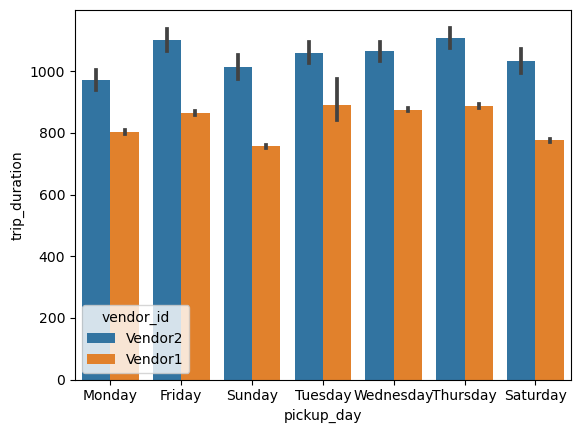

In [70]:
ax = sns.barplot(data=data, x=categorical_columns[1], y="trip_duration",hue='vendor_id')

From the above plot we observe that the <b>average_trip_duration</b> is higher for Vendor2 and the maximums occurs around <b>pickup_day</b> Thursday and Friday

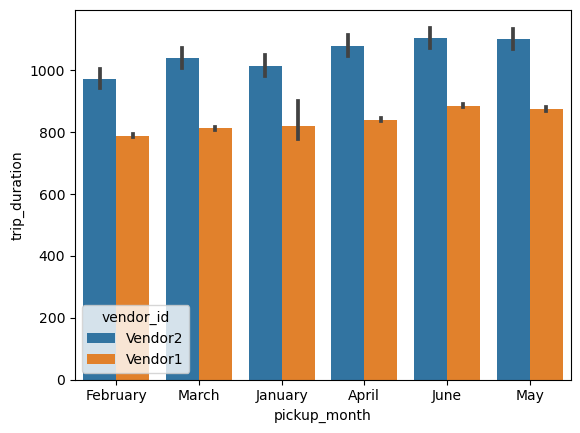

In [71]:
ax = sns.barplot(data=data, x=categorical_columns[2], y="trip_duration",hue='vendor_id')

From the above plot we observe that the <b>average_trip_duration</b> is higher for Vendor2 and the maximums occurs around <b>pickup_month</b> May and June

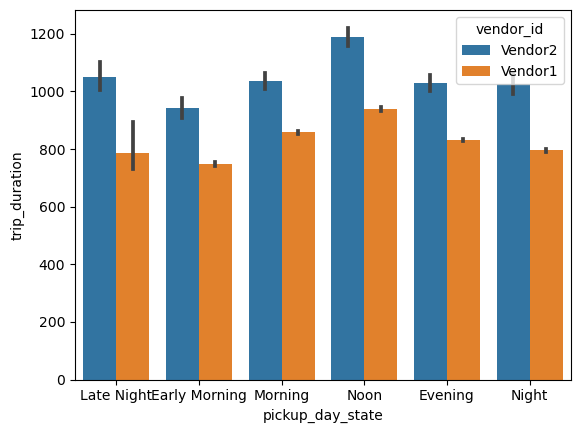

In [72]:
ax = sns.barplot(data=data, x=categorical_columns[3], y="trip_duration",hue='vendor_id')

From the above plot we observe that the <b>average_trip_duration</b> is higher for Vendor2 and the maximum occurs around <b>pickup_day_state</b> Noon

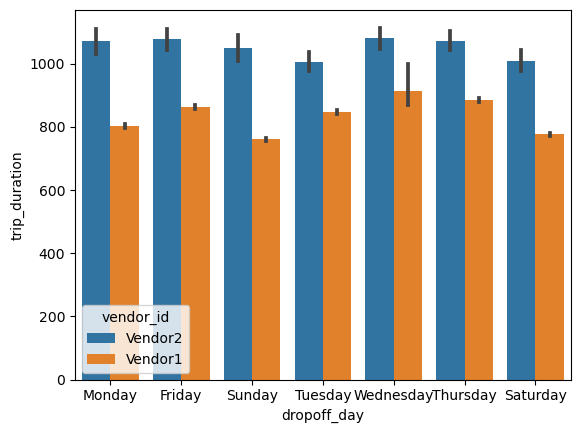

In [73]:
ax = sns.barplot(data=data, x=categorical_columns[4], y="trip_duration",hue='vendor_id')

From the above plot we observe that the <b>average_trip_duration</b> is higher for Vendor2 and the maximums occurs around <b>dropoff_day</b> Wednesday, Thursday and Friday

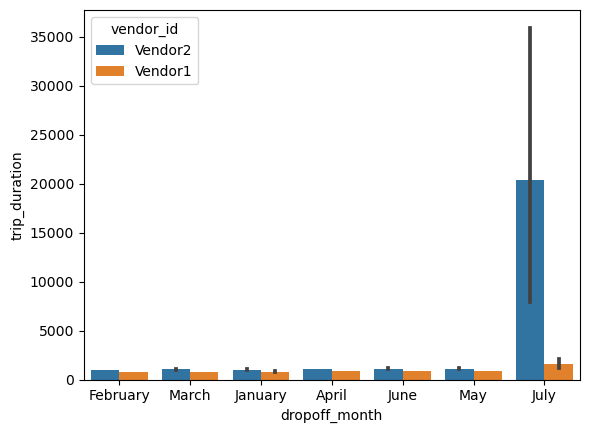

In [74]:
ax = sns.barplot(data=data, x=categorical_columns[5], y="trip_duration",hue='vendor_id')

From the above plot we observe that the <b>average_trip_duration</b> is higher for Vendor2 and the maximum occurs around <b>dropoff_month</b> July. This is considerably higher and as seen previously suggests presence of outlier

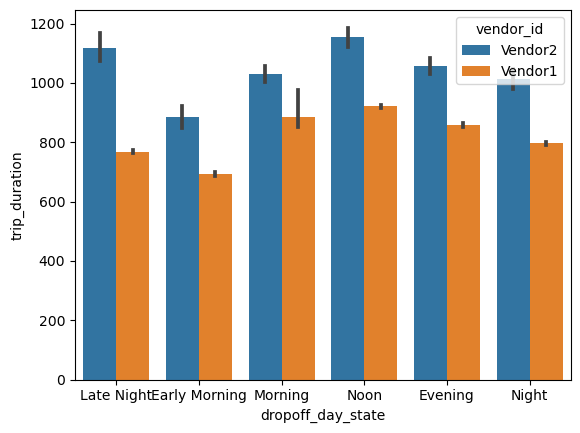

In [75]:
ax = sns.barplot(data=data, x=categorical_columns[6], y="trip_duration",hue='vendor_id')

From the above plot we observe that the <b>average_trip_duration</b> is higher for Vendor2 and the maximum occurs around <b>dropoff_day_state</b> Noon

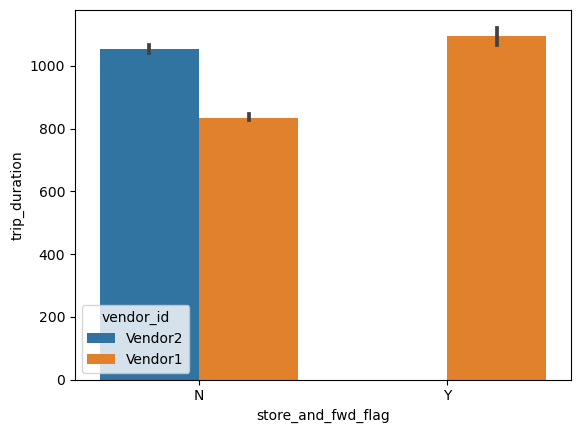

In [76]:
ax = sns.barplot(data=data, x=categorical_columns[7], y="trip_duration",hue='vendor_id')

From the above plot we observe that the Vendor1 taxis are storing the trip information but Vendor2 taxis are not storing the trip information. The Vendor2 taxis have a higher average <b>trip_duration</b> than Vendor 1 taxis when it is not storing the trip information 